<a href="https://colab.research.google.com/github/Itskindastrange/Seoul-Bike-Sharing-Demand-UCI-Dataset/blob/main/Seoul_Bike_Sharing_Demand_UCI_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
#!unzip -j /content/seoul+bike+sharing+demand.zip


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
import copy
import seaborn as sns
import tensorflow as tf
from sklearn.linear_model import LinearRegression

In [2]:
dataset_cols=["bike_count","hour","temp","humidity","wind","visibility","dew_pt_temp","radiation","rain","snow","functional"]
df=pd.read_csv("SeoulBikeData.csv").drop(['Date',"Holiday","Seasons"],axis=1)


In [3]:
df.columns=dataset_cols
df["functional"] = (df["functional"] == "Yes").astype(int)
#assuming its the same hour everytime so droopping that as well
df=df[df["hour"]==12]
df=df.drop("hour",axis=1)

In [4]:
df.head()

,bike_count,temp,humidity,wind,visibility,dew_pt_temp,radiation,rain,snow,functional
12,449,1.7,23,1.4,2000,-17.2,1.11,0.0,0.0,1
36,479,4.3,41,1.3,1666,-7.8,1.09,0.0,0.0,1
60,333,5.8,85,1.7,349,3.4,0.43,0.0,0.0,1
84,393,-0.3,38,4.8,1823,-12.9,1.11,0.0,0.0,1
108,321,-2.3,25,0.0,1962,-19.7,0.00,0.0,0.0,1


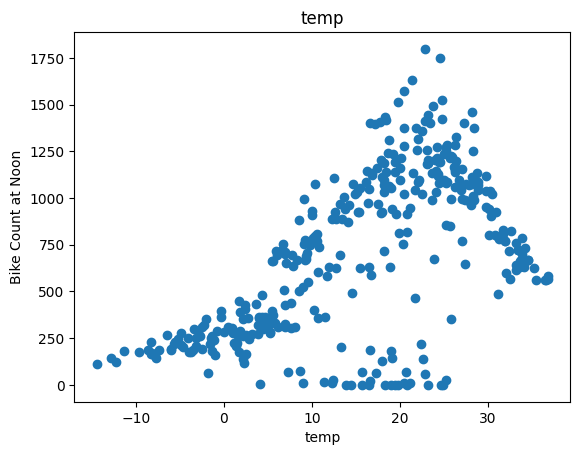

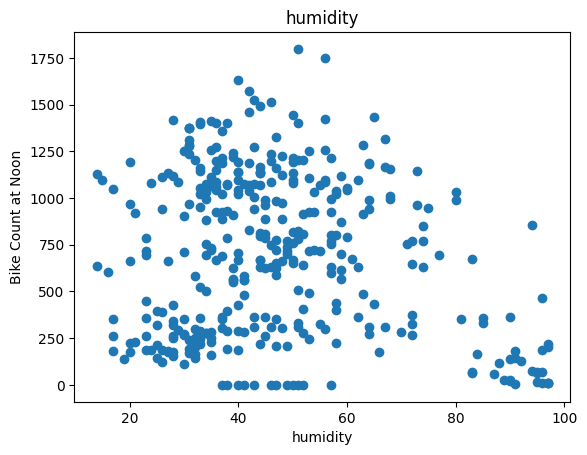

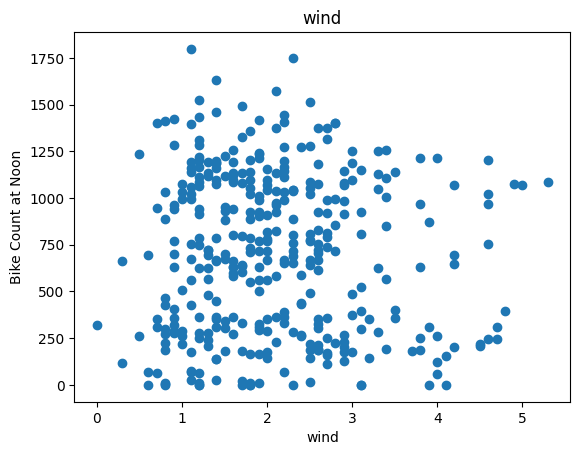

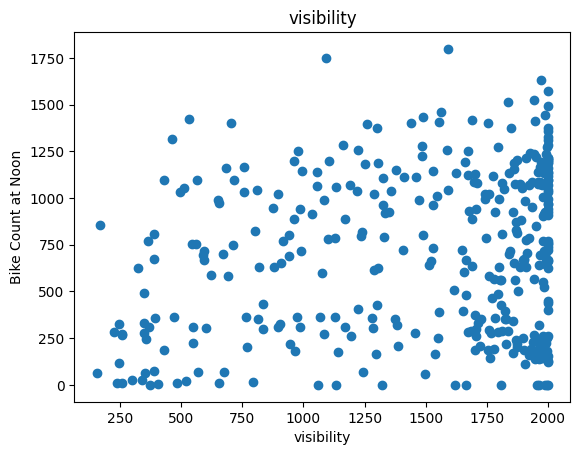

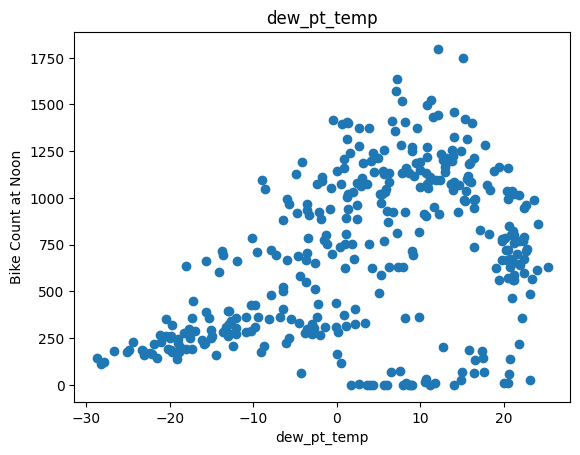

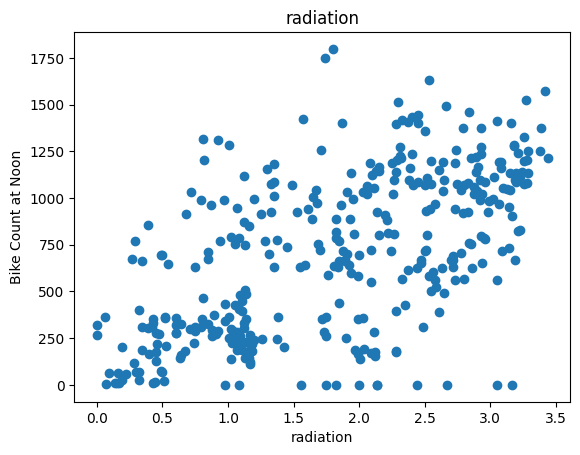

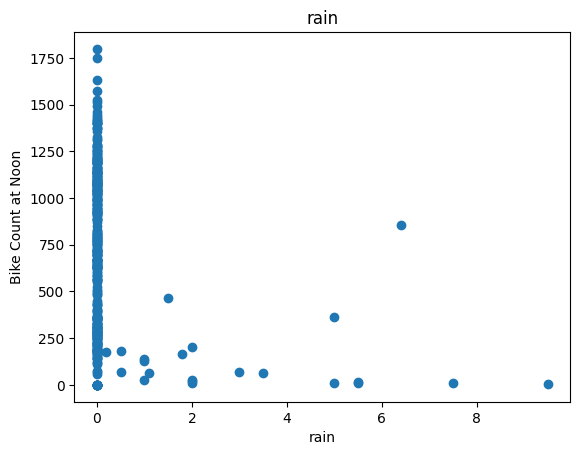

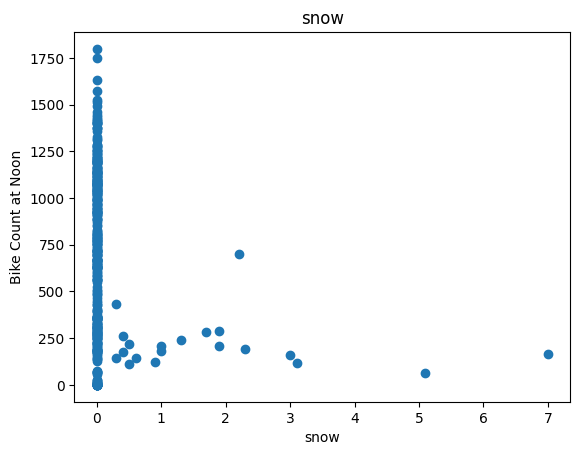

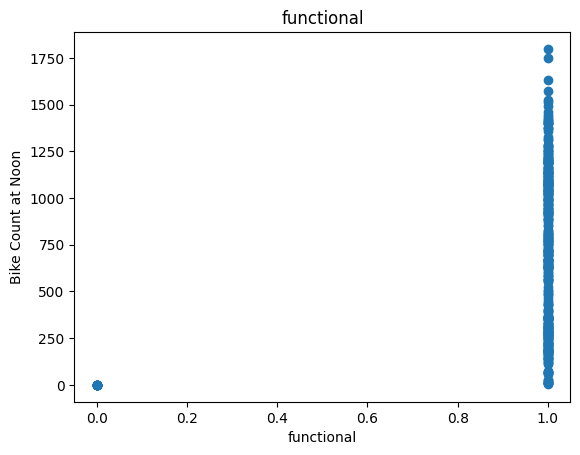

In [5]:
for label in df.columns[1:]:
  plt.scatter(df[label],df["bike_count"])
  plt.title(label)
  plt.xlabel(label)
  plt.ylabel("Bike Count at Noon")
  plt.show()

In [4]:
df=df.drop(['wind','visibility','functional'],axis=1)
df


,bike_count,temp,humidity,dew_pt_temp,radiation,rain,snow
12,449,1.7,23,-17.2,1.11,0.0,0.0
36,479,4.3,41,-7.8,1.09,0.0,0.0
60,333,5.8,85,3.4,0.43,0.0,0.0
84,393,-0.3,38,-12.9,1.11,0.0,0.0
108,321,-2.3,25,-19.7,0.00,0.0,0.0
...,...,...,...,...,...,...,...
8652,752,9.1,57,1.0,1.69,0.0,0.0
8676,672,9.3,61,2.1,0.85,0.0,0.0
8700,635,7.9,14,-18.0,1.81,0.0,0.0
8724,661,5.6,27,-11.9,0.34,0.0,0.0


#Train,Validation and Test Dataset

In [5]:
train,val,test=np.split(df.sample(frac=1),[int(.6*len(df)),int(.8*len(df))])

In [6]:
def get_xy(dataframe,y_label,x_labels=None):
  dataframe=copy.deepcopy(dataframe)
  if  x_labels is None:
    X=dataframe[[c for c in dataframe.columns if c!=y_label]].values
  else:
    if len(x_labels)==1:
      X=dataframe[x_labels[0]].values.reshape(-1,1)
    else:
      X=dataframe[x_labels].values

  y=dataframe[y_label].values.reshape(-1,1)
  data=np.hstack((X,y))
  return data,X,y

In [7]:
_ , X_train_temp , y_train_temp = get_xy(train,"bike_count",x_labels=["temp"])
_ , X_val_temp , y_val_temp = get_xy(val,"bike_count",x_labels=["temp"])
_ , X_test_temp , y_test_temp = get_xy(test,"bike_count",x_labels=["temp"])


In [38]:
temp_reg_Model = LinearRegression()
temp_reg_Model.fit(X_train_temp,y_train_temp)

LinearRegression()

In [15]:
print(temp_reg_Model.coef_)
print(temp_reg_Model.intercept_)

[[20.92174987]]
[393.86255414]


In [16]:
temp_reg_Model.score(X_train_temp,y_train_temp)

0.3049423318459086

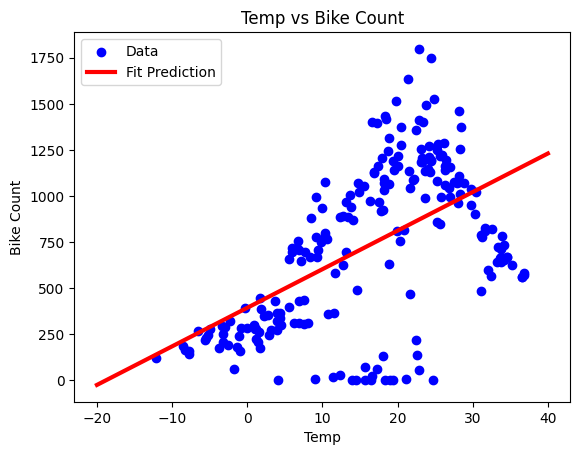

In [20]:
plt.scatter(X_train_temp,y_train_temp,label='Data',color='blue')
x=tf.linspace(-20,40,100)
plt.plot(x,temp_reg_Model.predict(np.array(x).reshape(-1,1)),label='Fit Prediction',color='red',linewidth=3)
plt.title("Temp vs Bike Count")
plt.xlabel("Temp")
plt.ylabel("Bike Count")
plt.legend()
plt.show()

#Multiple LR

In [8]:
_ , X_train_all , y_train_all = get_xy(train,"bike_count",x_labels=df.columns[1:])
_ , X_val_all , y_val_all = get_xy(val,"bike_count",x_labels=df.columns[1:])
_ , X_test_all , y_test_all = get_xy(test,"bike_count",x_labels=df.columns[1:])


In [9]:
all_reg_model=LinearRegression()
all_reg_model.fit(X_train_all,y_train_all)

LinearRegression()

In [26]:
all_reg_model.score(X_train_all,y_train_all)

0.47900161143192477

# ***Regression With NN***

Single neuron with temp only data

In [10]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('MSE')
  plt.legend()
  plt.grid(True)
  plt.show()

In [11]:
temp_normalizer=tf.keras.layers.Normalization(input_shape=(1,),axis=None)
temp_normalizer.adapt(X_train_temp.reshape(-1))

In [12]:
temp_nn_model=tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(1)
])

In [13]:
temp_nn_model.compile(tf.keras.optimizers.Adam(learning_rate=0.1),loss='mean_squared_error')

In [43]:
history=temp_nn_model.fit(
    X_train_temp.reshape(-1),y_train_temp,
    epochs=1000,
    verbose=0,
    validation_data=(X_val_temp,y_val_temp)
    )

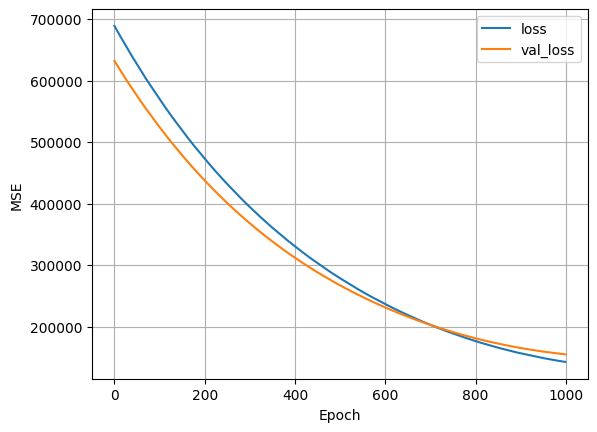

In [44]:
plot_loss(history)

4/4 [==============================] - 0s 4ms/step


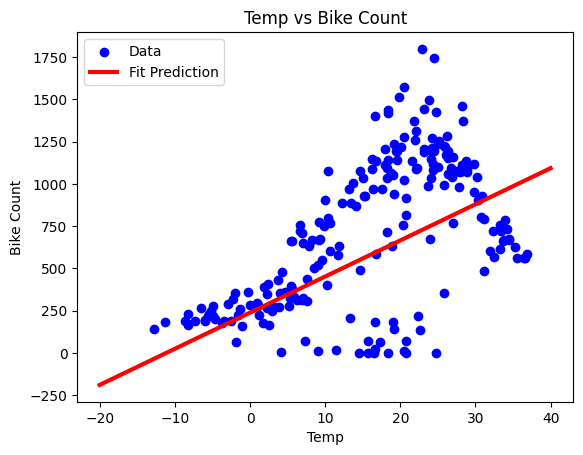

In [45]:
plt.scatter(X_train_temp,y_train_temp,label='Data',color='blue')
x=tf.linspace(-20,40,100)
plt.plot(x,temp_nn_model.predict(np.array(x).reshape(-1,1)),label='Fit Prediction',color='red',linewidth=3)
plt.title("Temp vs Bike Count")
plt.xlabel("Temp")
plt.ylabel("Bike Count")
plt.legend()
plt.show()

# Multiple LR with NN Single Node

# Complete NN

In [21]:
nn_model=tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(32,activation='relu'),
    tf.keras.layers.Dense(32,activation='relu'),
    tf.keras.layers.Dense(32,activation='relu'),
    tf.keras.layers.Dense(1)
])

nn_model.compile(tf.keras.optimizers.Adam(learning_rate=0.001),loss='mean_squared_error')

In [22]:
history=nn_model.fit(
    X_train_temp,y_train_temp,
    epochs=100,
    verbose=0,
    validation_data=(X_val_temp,y_val_temp)
    )

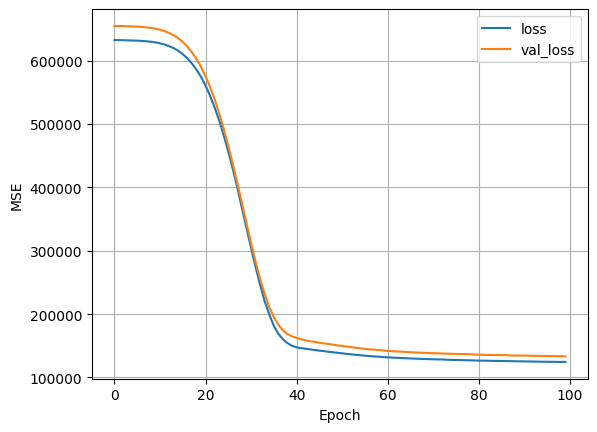

In [23]:
plot_loss(history)

4/4 [==============================] - 0s 3ms/step


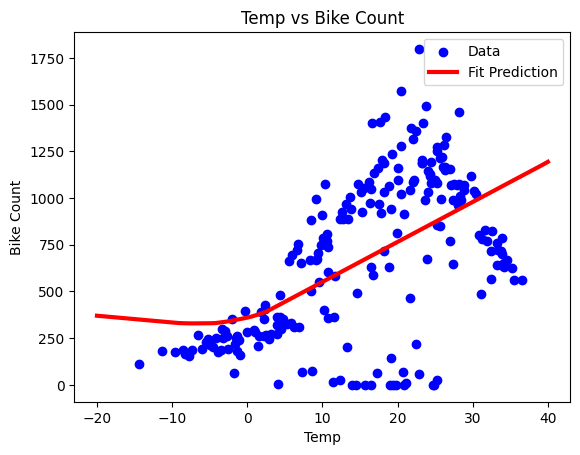

In [24]:
plt.scatter(X_train_temp,y_train_temp,label='Data',color='blue')
x=tf.linspace(-20,40,100)
plt.plot(x,nn_model.predict(np.array(x).reshape(-1,1)),label='Fit Prediction',color='red',linewidth=3)
plt.title("Temp vs Bike Count")
plt.xlabel("Temp")
plt.ylabel("Bike Count")
plt.legend()
plt.show()

# NN with Multiple Inputs

In [37]:
all_normalizer=tf.keras.layers.Normalization(input_shape=(6,),axis=-1)
all_normalizer.adapt(X_train_all)



In [38]:
nn_model=tf.keras.Sequential([
    all_normalizer,
    tf.keras.layers.Dense(32,activation='relu'),
    tf.keras.layers.Dense(32,activation='relu'),
    tf.keras.layers.Dense(1)
])

nn_model.compile(tf.keras.optimizers.Adam(learning_rate=0.001),loss='mean_squared_error')

In [39]:
history=nn_model.fit(
    X_train_all,y_train_all,
    epochs=100,
    verbose=0,
    validation_data=(X_val_all,y_val_all)
    )

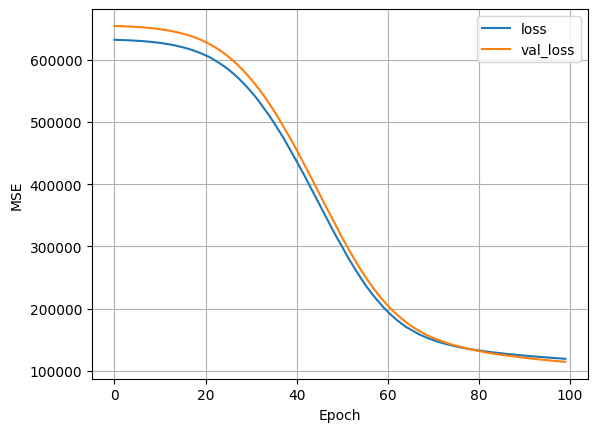

In [40]:
plot_loss(history)

In [41]:
#calculate MSE for both LR and NN

y_pred_all_lr= all_reg_model.predict(X_test_all)
y_pred_nn= nn_model.predict(X_test_all)

3/3 [==============================] - 0s 4ms/step


In [42]:
def MSE(y_pred , y_real):
  return (np.square(y_pred - y_real)).mean()

In [35]:
MSE(y_pred_all_lr,y_test_all)  #for LR

105888.16902598931

In [43]:
MSE(y_pred_nn , y_test_all)  #for NN

140817.85522294234

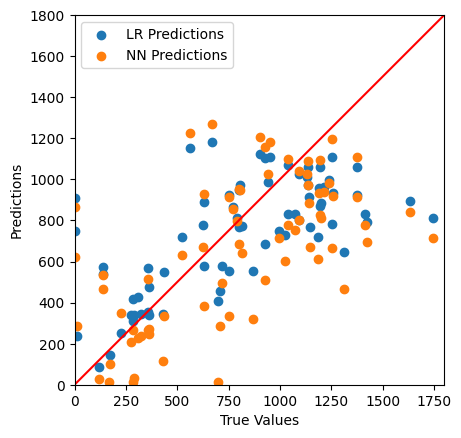

In [47]:
ax=plt.axes(aspect='equal')
plt.scatter(y_test_all , y_pred_all_lr ,label='LR Predictions')
plt.scatter(y_test_all , y_pred_nn ,label='NN Predictions')
plt.xlabel("True Values")
plt.ylabel("Predictions")
lims=[0,1800]
plt.xlim(lims)
plt.ylim(lims)
plt.legend()
_ = plt.plot(lims,lims,'red')